In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LAMBDA = 0.03114

In [205]:
raw_data = pd.read_excel('../../../Downloads/COL17-3_gamma_08292018.xlsx', 1)
needed_data = pd.DataFrame()
needed_data['depth_low'] = raw_data['dpeth_low']
needed_data['volume'] = raw_data['volume (cm3)']
needed_data['weight'] = raw_data['weight (g)']
needed_data['210pb'] = raw_data['210Pb']
needed_data['210pb_err'] = raw_data['err']

In [219]:
def get_crs_age(depth_low, volume, weight, pb, equilbrium_row, pb_err, p = 0.07, A_0_method = 'default', ref_line = None, ref_year = None):
    
    if A_0_method == 'refdate':
        assert ref_line is not None
        assert ref_year is not None
    
    pb_bkg = np.mean(pb[equilbrium_row:])
    density = (weight / volume)
    c = (pb - pb_bkg)
    m = []
    for i, density_i in enumerate(density):
        if i == 0:
            m_i = density_i * depth_low[i]
        else:
            m_i = m[i-1] + density_i * (depth_low[i] - depth_low[i-1])
        m.append(m_i)
    m = np.asarray(m)
    
    a_hat = []
    a_hat_err = []
    for i, c_i in enumerate(c):
        if i == 0:
            a_hat_i = c_i * m[i] / 2
            a_hat_i_err = np.sqrt((pb_err[i]**2 + c_i**2 * p**2) * m[i]**2)
        else:
            a_hat_i = a_hat[i-1] + (c_i + c[i-1]) * (m[i] - m[i-1]) / 2
            a_hat_i_err = np.sqrt((pb_err[i]**2 + c_i**2 * p**2) * (m[i] - m[i-1])**2)
        a_hat.append(a_hat_i)
        a_hat_err.append(a_hat_i_err)
    a_hat = np.asarray(a_hat)
    a_hat_err = np.asarray(a_hat_err)

    a_0, a_0_err = get_A_0(a_hat, a_hat_err, c, m, pb, pb_err, equilbrium_row, A_0_method, ref_line, ref_year)
    
    t = 1 / LAMBDA * np.log(a_0 / (a_0 - a_hat))
    t_err = 1 / LAMBDA * np.sqrt(np.abs((a_0_err/a_0)**2 + (1 - 2*(a_0 - a_hat)/a_0) * (a_0_err**2 + a_hat_err**2)/(a_0-a_hat)**2))
    
    return t[:equilbrium_row], t_err[:equilbrium_row]

In [220]:
def get_A_0(a_hat, a_hat_err, c, m, pb, pb_err, equilbrium_row, A_0_method, ref_line, ref_year):
    if A_0_method == 'default':
        A_0 = (a_hat[equilbrium_row-1] + c[equilbrium_row-1] * (m[equilbrium_row] - m[equilbrium_row-1]) / 2) * np.ones(np.shape(a_hat))
        A_0_err = np.sqrt(pb_err[equilbrium_row-1]**2 + a_hat_err[equilbrium_row-1]**2) * np.ones(np.shape(a_hat))
        
    if A_0_method == 'refdate':
        A_0 = ((a_hat[ref_line] + a_hat[ref_line]/(np.exp(LAMBDA * ref_year) - 1)) * np.heaviside(ref_line - np.arange(0, len(a_hat), 1), 1)
              + (a_hat[equilbrium_row-1] + c[equilbrium_row-1] * (m[equilbrium_row] - m[equilbrium_row-1]) / 2) * np.heaviside(np.arange(0, len(a_hat), 1) - ref_line, 0))
        A_0_err = (np.sqrt(pb_err[ref_line]**2 + a_hat_err[ref_line]**2) * np.heaviside(ref_line - np.arange(0, len(a_hat), 1), 1)
                   + (np.sqrt(pb_err[equilbrium_row-1]**2 + a_hat_err[equilbrium_row-1]**2) * np.ones(np.shape(a_hat)) * np.heaviside(np.arange(0, len(a_hat), 1) - ref_line, 0)))
    
    return A_0, A_0_err

In [226]:
time, tu = get_crs_age(needed_data['depth_low'], needed_data['volume'], needed_data['weight'], needed_data['210pb'], 12, needed_data['210pb_err'], 
            A_0_method = 'default', ref_line = 22, ref_year = 57)

In [222]:
time2, t2u = get_crs_age(needed_data['depth_low'], needed_data['volume'], needed_data['weight'], needed_data['210pb'], 12, needed_data['210pb_err'], 
            A_0_method = 'refdate', ref_line = 6, ref_year = 54)

In [251]:
def plot_years(depths, years, yr_err):
    fig, ax = plt.subplots(figsize = (10,10))
    ax.errorbar(years, depths[:len(years)], xerr = yr_err, fmt = 'o')
    ax.invert_yaxis()
    ax.set_ylabel('Depth (cm)')
    ax.set_xlabel('Year')
    ax.grid(alpha = 0.5)
    plt.show


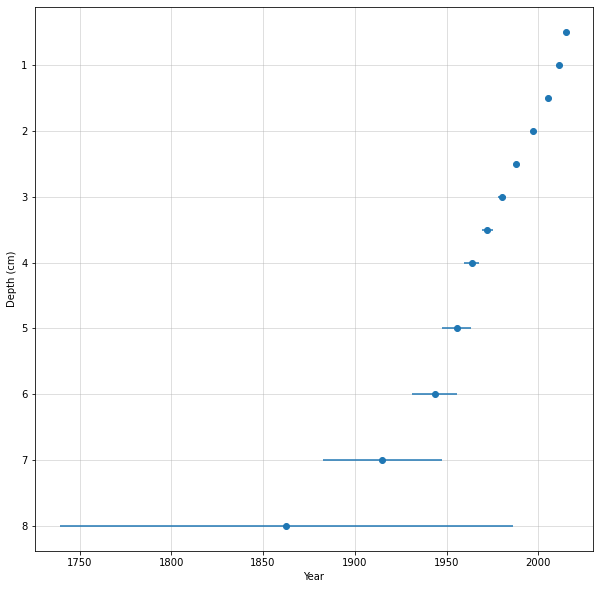

In [252]:
plot_years(needed_data['depth_low'], 2017-time, tu)

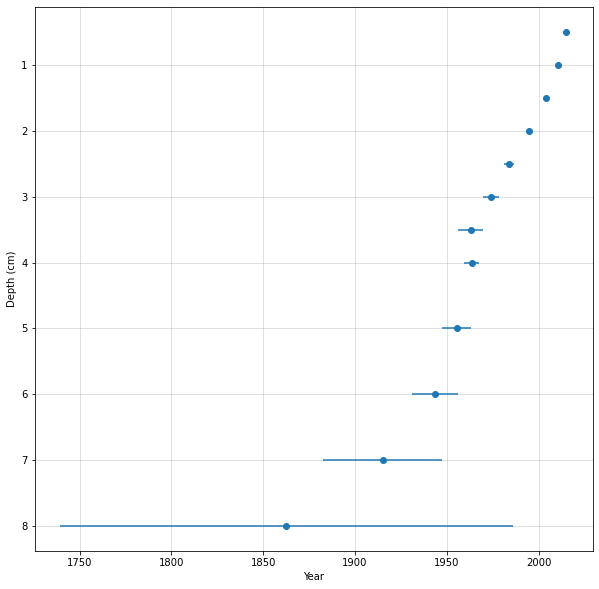

In [250]:
plot_years(needed_data['depth_low'], 2017-time2, t2u)